## Basic benchmarks on Nngpr
This notebooks runs Nngpr and the standard Gaussian Process Regressor on a bucnh of toy datasets. This cannot be considered a reliable benchmark, but gives an idea of the size of datasets that can be handled by Nngpr.

If you want to jump to the results, just scroll till the end of the notebook where you can find some plots based on pre-calculated results on my own hardware.

If you want to rerun this notebook on your hardware, it requires `matplotlib` and `ucimlrepo` packages, next to `scikit-learn` of course. `cupy`, `torch` and `gpytorch` are needed to run all the models offered in this notebook, however you can exclude them if you don't have such libraries (see first cell).

In [1]:
import os
import time
import warnings

import scipy
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn import metrics
from sklearn import datasets as sk_datasets
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from ucimlrepo import fetch_ucirepo

from nngpr.numpy_nngpr import NumpyNngpr
from nngpr import batched_kernels

use_cuda_nngpr = True  # Set to True if you want to benchmark CudaNngpr
use_torch_nngpr = True  # Set to True if you want to benchmark TorchNngpr.
use_gpytorch_sgpr = False  # Set to True if you want to benchmark Gpytorch Sgpr. Currently excluded because of bad performance (could be misused)
# BEWARE: GPytorch SGPR may give out of memory errors. You may need to manually save results to a file, restart the kernel, 
# then continue the benchmark to avoid such errors. Looks like GPU memory may not be completelly released when the model
# is fitted.
# Side-note: there are other very interesting models in the GPytorch library that could be added to this notebook for
# comparison. If you would like to contribute by adding such models in this benchamr notebook, or by adding other dataset, 
# any contribution is welcome. I personally found some GPytorch models a bit hard to get them working due to runtime
# errors coming from, e.g. out of memory or lack of positive definiteness.

In [2]:
# Try importing optional libraries
torch_has_cuda = False

if use_cuda_nngpr:
    try:
        from nngpr.cuda_nngpr import CudaNngpr
    except ImportError:
        print("Unable to import cuda_nngpr, probably 'cupy' dependency is not installed, will not benchmark CudaNngpr")
        use_cunngpr = False

if use_torch_nngpr:
    try:
        from nngpr.torch_nngpr import TorchNngpr
        import torch
        torch_has_cuda = torch.cuda.is_available()
    except ImportError:
        print("Unable to import torch_nngpr, probably 'torch' dependency is not installed, will not benchmark TorchNngpr")
        use_torch_nngpr = False

if use_gpytorch_sgpr:
    try:
        import gpytorch
        import torch
        torch_has_cuda = torch.cuda.is_available()
    except ImportError:
        print("Unable to import gpytorch, will not benchmark GPytorch models")
        use_gpytorch_sgpr = False

## Config

In [3]:
# Choose datas ets to run. Can choose among 'Elevators', '3droad', 'California_housing', 'Gas_turbine_nox'
dset_names = ['Elevators', '3droad', 'California_housing', 'Gas_turbine_nox']
dset_dims = [3000, 10000, 20000, 50000, 100000, 200000]  # Each dataset is truncated to the size specified here. If the size is
# larger than the dataset size, the run will be skipped
models_to_run = ['GP', 'NumpyNngpr-32', 'NumpyNngpr-64']
if use_cuda_nngpr:
    models_to_run += ['CudaNngpr-32', 'CudaNngpr-64', 'CudaNngpr-128']
if use_torch_nngpr:
    models_to_run += ['TorchNngpr-32', 'TorchNngpr-64']
    if torch_has_cuda:
        models_to_run += ['TorchNngpr-128']
if use_gpytorch_sgpr:
    models_to_run += ['Sgpr-100', 'Sgpr-200', 'Sgpr-400']
max_gp_dset_size = 15000  # Datasets of bigger size will not be fitted by the plain Gaussian Process Regressor. Change based on you RAM size
max_noncuda_gp_dset_size = 20000  # Datasets of bigger size will not be fitted by non cuda-based models. 
test_perc = 0.2  # Define test set fraction
n_restarts_optimizer = 3  # Number of optimization restarts from different initial points
random_seed = 2380
results = {}

## Datasets

In [5]:
def get_dset(dset_name):
    if dset_name == 'Elevators':  # Taken from GPytorch examples
        data = scipy.io.loadmat('datasets/elevators.mat')['data']
        y = data[:, -1]
        X = data[:, :-1]
        del data
        
    elif dset_name == '3droad':  # Taken from GPytorch examples
        data = scipy.io.loadmat('datasets/3droad.mat')['data']
        X = data[:, :-1]
        y = data[:, -1]
        del data

    elif dset_name == 'California_housing':
        data = sk_datasets.fetch_california_housing()
        X = data['data']
        y = data['target']

    elif dset_name == 'Gas_turbine_nox':
        data = fetch_ucirepo(id=551)
        X = data.data.features.values
        y = X[:, -1]
        X = X[:, :-1]
        
    else:
        raise NotImplementedError(dset_name)
        
    X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    assert(np.all(np.isfinite(X)))
    y = (y - np.mean(y)) / np.std(y)
    assert(np.all(np.isfinite(y)))
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_perc, random_state=981234)

    return x_train, y_train, x_test, y_test


## Define fitting functions

In [6]:
def get_kern(x):
    return kernels.ConstantKernel(1e-1) * kernels.RBF(1e-1*np.ones(x.shape[1])) + kernels.WhiteKernel(1e-1)

def get_batched_kern(x):
    return batched_kernels.ConstantKernel(1e-1) * batched_kernels.RBF(1e-1*np.ones(x.shape[1])) + batched_kernels.WhiteKernel(1e-1)

def fit_gp_mdl(x, y, x_test):
    mdl = GaussianProcessRegressor(kernel=get_kern(x), alpha=1e-8, n_restarts_optimizer=n_restarts_optimizer, random_state=random_seed)
    mdl.fit(x, y)
    return mdl.predict(x_test)

def fit_nngpr_mdl(x, y, x_test, num_nn=32):
    # To make a fair comparison, use the same number of jobs as the one used by the openblas, MKL, or similars. Indeed, standard GP performs operations on large matrices
    # which are done in parallel by Blas libraries, while NNGPR works with small matrices which are typically executed sequentially
    num_workers = int(os.getenv('MKL_NUM_THREADS', os.getenv('OPENBLAS_NUM_THREADS', os.getenv('BLIS_NUM_THREADS', os.cpu_count()))))
    mdl = NumpyNngpr(kernel=get_batched_kern(x), alpha=1e-8, n_restarts_optimizer=n_restarts_optimizer, num_nn=num_nn, num_workers=num_workers, random_state=random_seed)
    mdl.fit(x, y)
    return mdl.predict(x_test)
    
fit_functions = {
    'GP': fit_gp_mdl,
    'NumpyNngpr': fit_nngpr_mdl,
}

In [7]:
if use_cuda_nngpr:
    def fit_cuda_nngpr_mdl(x, y, x_test, num_nn=64):
        mdl = CudaNngpr(kernel=get_batched_kern(x), alpha=1e-8, n_restarts_optimizer=n_restarts_optimizer, num_nn=num_nn, random_state=random_seed)
        mdl.fit(x, y)
        return mdl.predict(x_test)

    fit_functions['CudaNngpr'] = fit_cuda_nngpr_mdl

if use_torch_nngpr:
    def fit_torch_nngpr_mdl(x, y, x_test, num_nn=64):
        device = 'cuda' if torch_has_cuda else 'cpu'
        mdl = TorchNngpr(device, kernel=get_batched_kern(x), alpha=1e-8, n_restarts_optimizer=n_restarts_optimizer, num_nn=num_nn, random_state=random_seed)
        mdl.fit(x, y)
        return mdl.predict(x_test)
    
    fit_functions['TorchNngpr'] = fit_torch_nngpr_mdl

In [8]:
if use_gpytorch_sgpr:

    class GPytorchModel(gpytorch.models.ExactGP):
        
        def __init__(self, train_x, train_y, likelihood, inducing_points: int = 0):
            super().__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            rbf_kern = gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
            covar = gpytorch.kernels.ScaleKernel(rbf_kern)
            if inducing_points > 0:
                self.base_covar_module = covar
                self.covar_module = gpytorch.kernels.InducingPointKernel(
                    self.base_covar_module, 
                    inducing_points=train_x[np.random.choice(np.arange(train_x.shape[0]), inducing_points)].clone(),
                    likelihood=likelihood)
            else:
                self.base_covar_module = None
                self.covar_module = covar

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
        def predict(self, x):
            if torch_has_cuda:
                x = x.to('cuda')
            return self(x).detach().numpy()
        
    def fit_pytorch_mdl(
        x_torch, y_torch, x_test_torch, get_mdl_lkl, random_init_mdl, do_print=False, num_restarts=n_restarts_optimizer, 
        lr=[0.1, 0.02], max_training_iter=600, max_non_decrease_iter=200, get_optimizer=None):

        # Default vars
        if type(lr) not in [list, tuple]:
            lr = (lr,)
        if type(max_training_iter) not in [list, tuple]:
            max_training_iter = (max_training_iter,) * len(lr)
        if type(max_non_decrease_iter) not in [list, tuple]:
            max_non_decrease_iter = (max_non_decrease_iter,) * len(lr)
        assert len(max_training_iter) == len(lr)
        assert len(max_non_decrease_iter) == len(lr)

        best_global_loss = np.inf
        best_global_params = None
        for i_restart in range(num_restarts + 1):

            model, likelihood = get_mdl_lkl()
            model.train()
            likelihood.train()

            # "Loss" for GPs - the marginal log likelihood
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
            best_run_params = None
            best_run_loss = np.inf

            if i_restart > 0:
                random_init_mdl(model)

            for i_lr, (this_lr, mti, mndi) in enumerate(zip(lr, max_training_iter, max_non_decrease_iter)):
                
                if i_lr > 0:
                    model.initialize(**{param[0]: param[1] for param in best_run_params})
                non_decrease_iter = 0

                # Create the adam optimizer
                if get_optimizer is None:
                    optimizer = torch.optim.Adam(model.parameters(), lr=this_lr)  # Includes GaussianLikelihood parameters
                else:
                    optimizer = get_optimizer(model, this_lr)
                
                for i in range(mti):
                    # Zero gradients from previous iteration
                    optimizer.zero_grad()
                    # Output from model
                    output = model(x_torch)
                    # Calc loss and backprop gradients
                    loss = -mll(output, y_torch)
                    loss.backward()

                    this_loss = loss.item()

                    if do_print and ((i+1) % 50 == 0):
                        print('Restart %d - LR %.2e (%d/%d), Iter %d/%d - Loss: %.3f' % (  #    lengthscale: %.3f   noise: %.3f
                            i_restart, this_lr, i_lr +1, len(lr), i + 1, mti, this_loss,
                            # model.covar_module.base_kernel.lengthscale.item(), model.likelihood.noise.item()
                        ))

                    if this_loss < best_global_loss:
                        best_global_params = tuple(model.named_parameters())

                    if this_loss < best_run_loss:
                        best_run_params = tuple(model.named_parameters())
                        non_decrease_iter = 0
                        best_run_loss = this_loss
                    else:
                        non_decrease_iter += 1
                        if non_decrease_iter >= mndi:
                            break

                    optimizer.step()

        # Set the best params
        model.initialize(**{param[0]: param[1] for param in best_global_params})

        model.eval()
        likelihood.eval()
        
        pred = model(x_test_torch)
        return pred.mean.detach().cpu().numpy()


    def fit_sgpr_mdl(x, y, x_test, num_nn):  # num_nn is actually number of inducing points
        
        x, y, x_test = torch.asarray(x), torch.asarray(y), torch.asarray(x_test)

        if torch_has_cuda:
            x, y, x_test = x.to('cuda'), y.to('cuda'), x_test.to('cuda')
        
        def get_mdl_lkl(x=x, y=y):
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model = GPytorchModel(x, y, likelihood, inducing_points=num_nn)

            if torch_has_cuda:
                model, likelihood = model.to('cuda'), likelihood.to('cuda')

            return model, likelihood

        rng = np.random.default_rng(random_seed)

        def random_init_mdl(mdl):
            hl = 2
            params = {
                'base_covar_module.outputscale': 10**(rng.uniform(low=-hl, high=hl)),
                'base_covar_module.base_kernel.lengthscale': 10**(rng.uniform(low=-hl, high=hl)),
                'likelihood.noise_covar.noise': 10**(rng.uniform(low=-hl, high=hl)),
                'covar_module.inducing_points': x[rng.choice(np.arange(x.shape[0]), num_nn)].clone(),
            }
            mdl.initialize(**params)
            
        return fit_pytorch_mdl(x, y, x_test, get_mdl_lkl, random_init_mdl)
        
    fit_functions['Sgpr'] = fit_sgpr_mdl

## Run models

In [ ]:
for dset_name in dset_names:
    if dset_name not in results:
        results[dset_name] = {}
    dset_res = results[dset_name]
    x_train, y_train, x_test, y_test = get_dset(dset_name)
    print(dset_name, x_train.shape)
    
    for n in dset_dims:
        if n not in dset_res:
            dset_res[n] = {}
        this_res = dset_res[n]
        
        for name in models_to_run:
            tag = name
            kwargs = {}
            if (n > x_train.shape[0]) or (name in this_res):
                continue
            if (name == 'GP') and (n > max_gp_dset_size):  # Prevent out of memory
                continue
            if (name.startswith('NumpyNngpr') or not torch_has_cuda or name == 'GP') and (n > max_noncuda_gp_dset_size):
                continue  # Not a cuda model, prevent long runtime
            if '-' in name:
                tmp = name.split('-')
                tag = tmp[0]
                kwargs['num_nn'] = int(tmp[1])

            if (tag == 'Sgpr') and (kwargs['num_nn'] > 300) and (n > 100000):
                continue  # Gives out of memory error in my hardware
                
            print("Running", dset_name, name, n)

            t0 = time.time()
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                pred = fit_functions[tag](x_train[:n], y_train[:n], x_test, **kwargs)
            t = (time.time() - t0) / n_restarts_optimizer
            # metric = metrics.r2_score(y_test, pred)
            this_res[name] = {
                'time': t,
                'pred': pred,
                'y_test': y_test
            }
            if torch_has_cuda:
                torch.cuda.empty_cache()  # GPyTorch models tend not to release GPU memory on exit

print("All done")

## Plot results
Current results based on Ryzen 9700X and RTX4070S

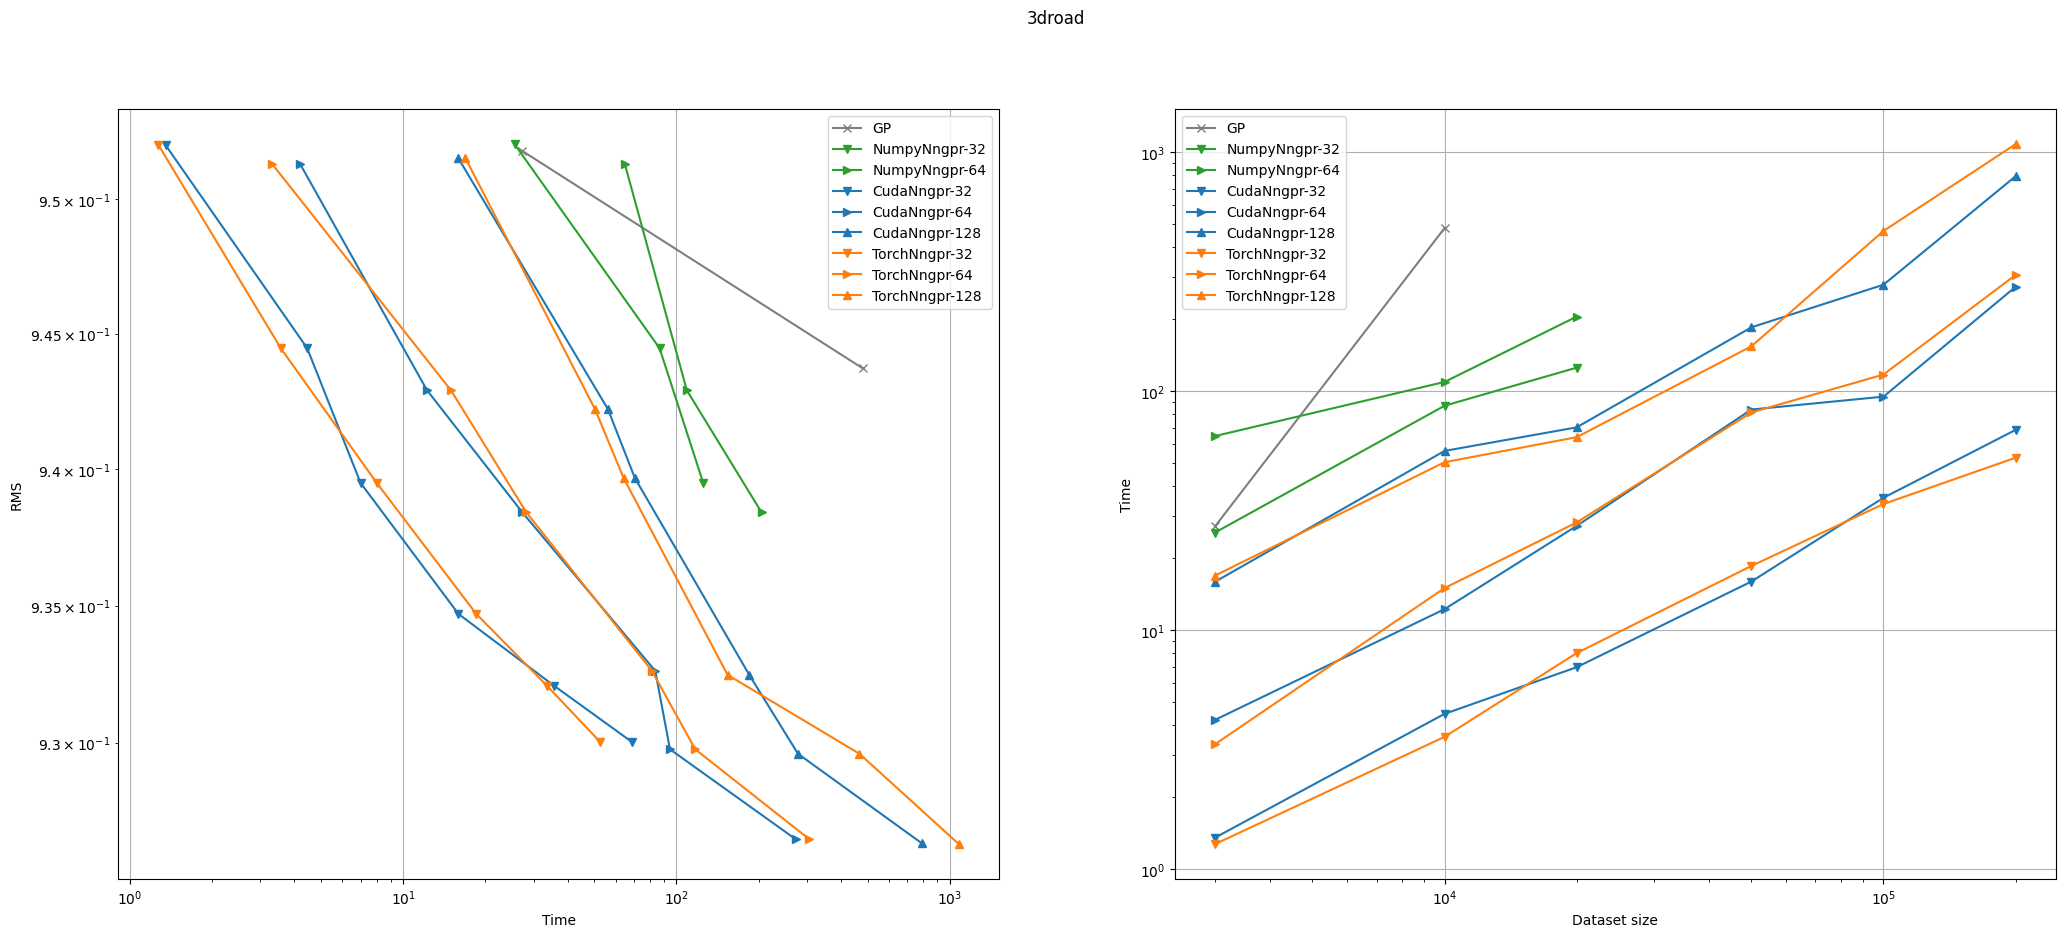

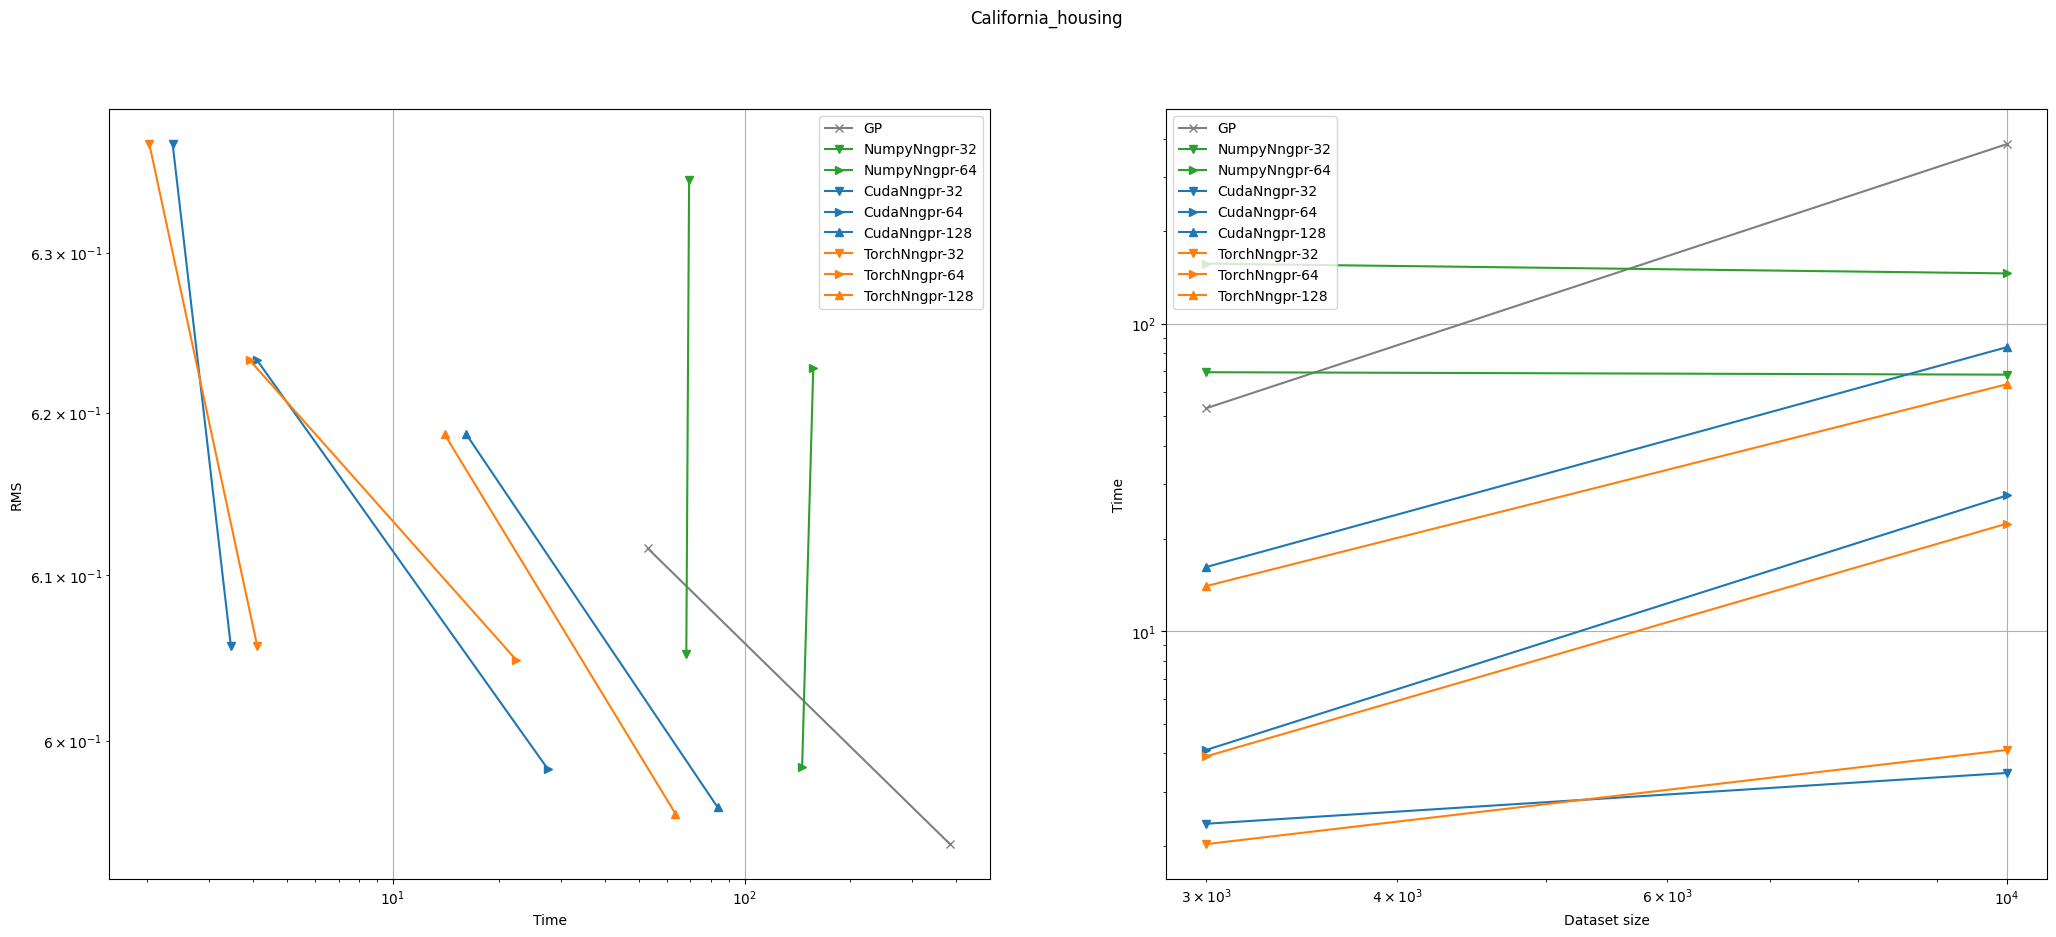

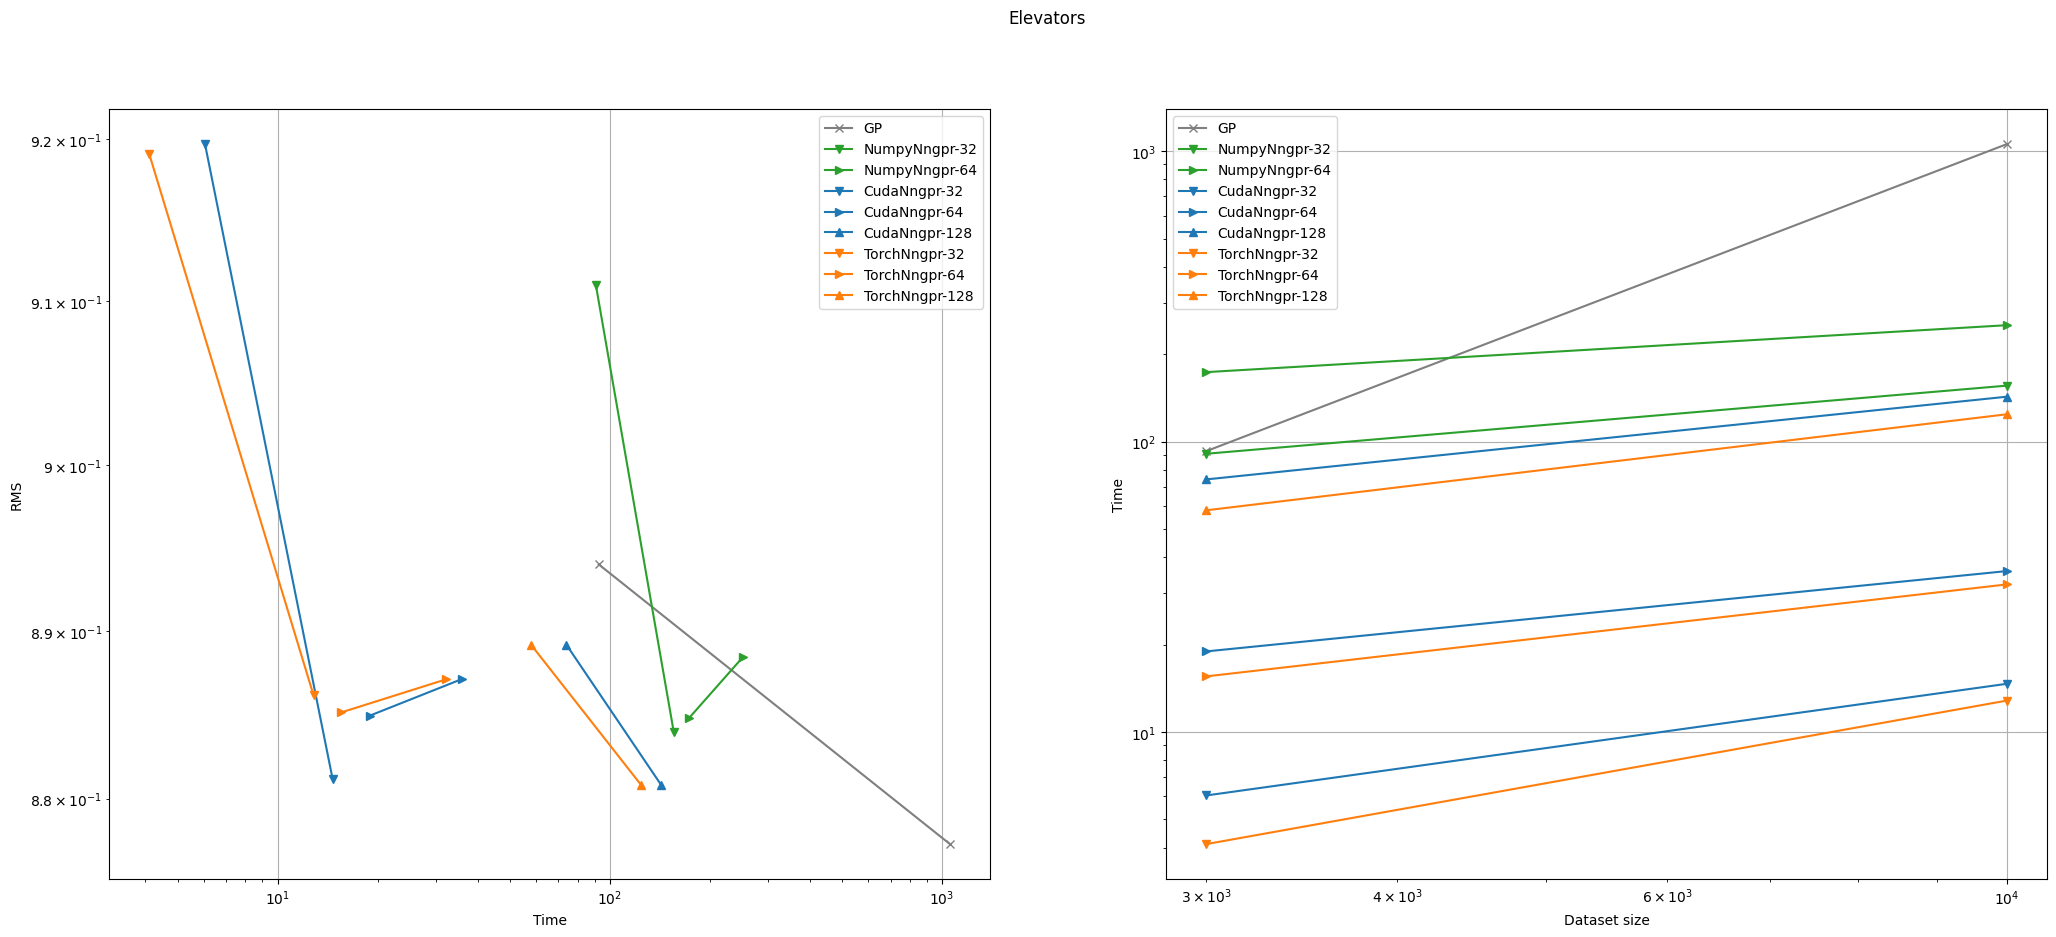

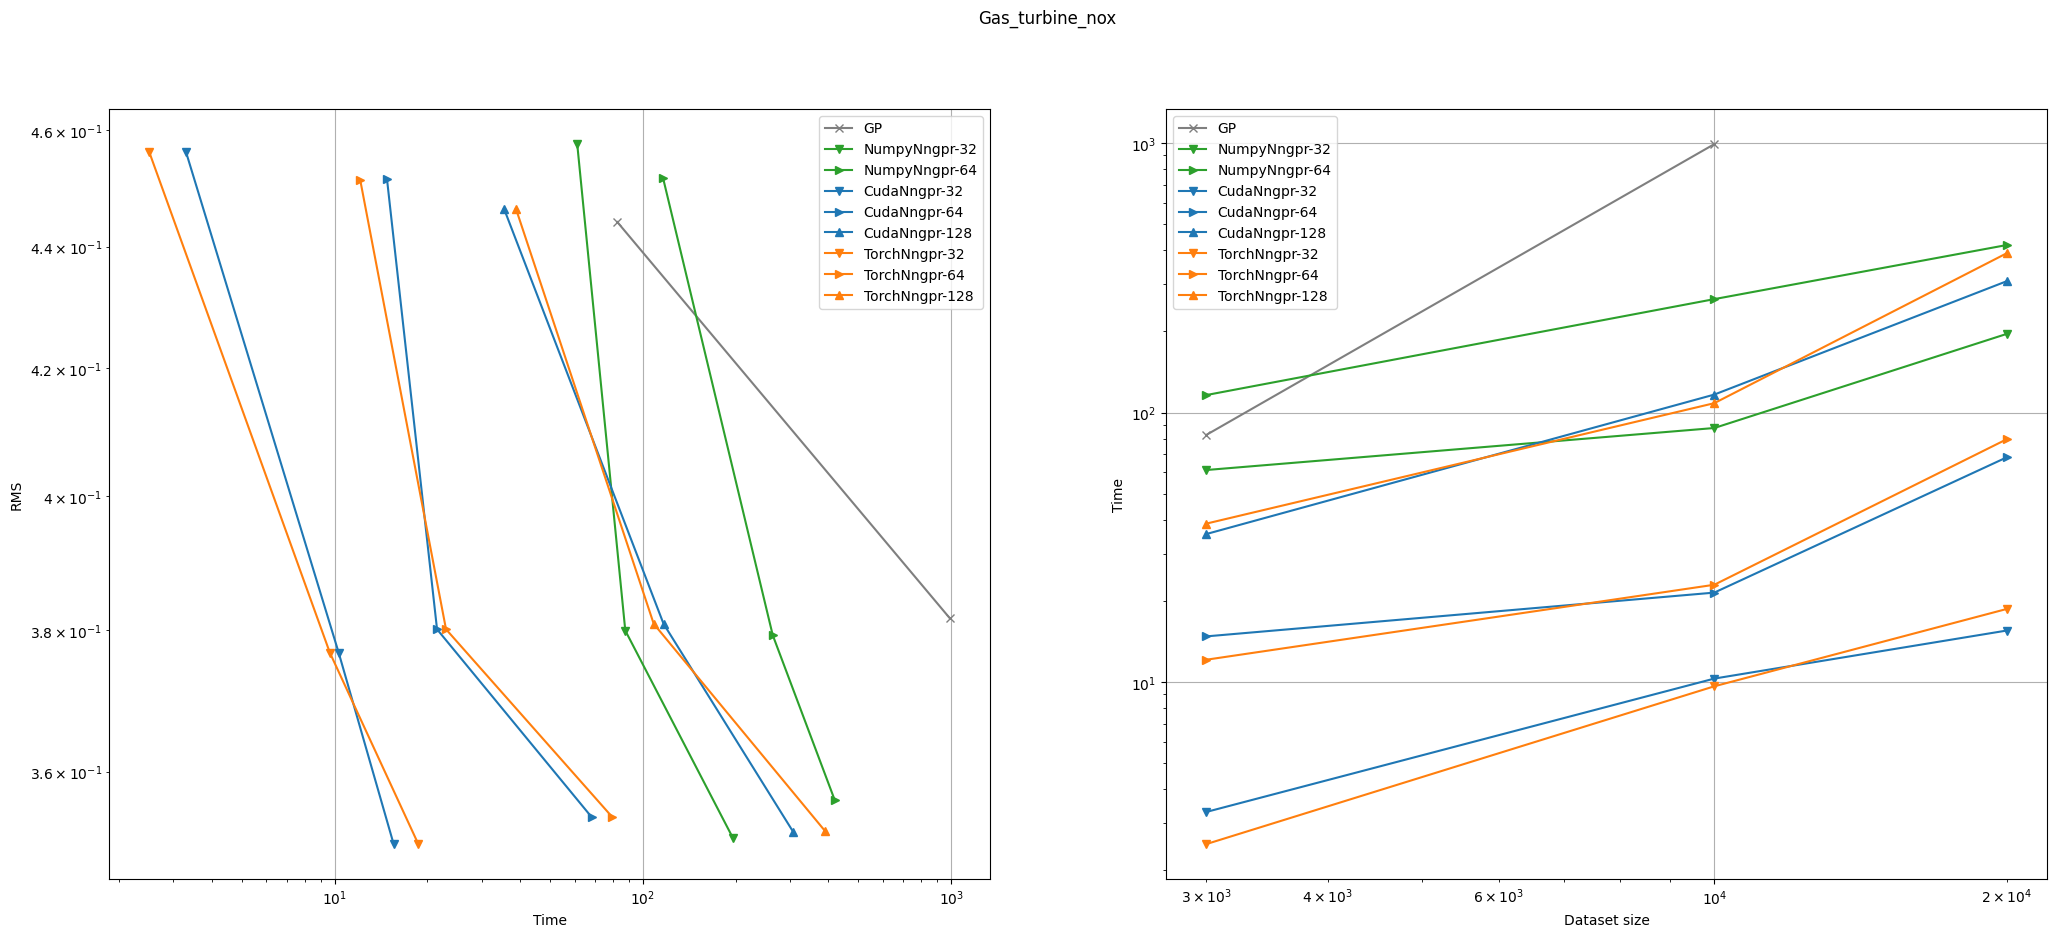

In [23]:
marks = ['o', '^', 'x', '.']
color_list = sorted(mcolors.TABLEAU_COLORS.keys())
params_to_mark = {
    None: 'x',

    # num_nn
    32: 'v',
    64: '>',
    128: '^',
    256: '<',

    # Other parameters
    100: '1',
    200: '2',
    400: '3',
}

def name_to_colorname(x):
    return x if '-' not in x else x.split('-')[0]

def name_to_markname(x):
    return None if '-' not in x else int(x.split('-')[1])
    
for dset_name in sorted(results):

    # Collect data to be plotted
    dset_results = results[dset_name]
    to_plot = {}
    for n, res in dset_results.items():
        for name, data in res.items():
            if name not in to_plot:
                to_plot[name] = {'time': [], 'metric': [], 'n': []}
            to_plot[name]['time'].append(data['time'])
            to_plot[name]['metric'].append(metrics.root_mean_squared_error(data['y_test'], data['pred']))
            to_plot[name]['n'].append(n)

    for name in list(to_plot.keys()):
        tmp = to_plot[name]
        sorter = np.argsort(tmp['n'])
        to_plot[name] = {'time': np.array(tmp['time'])[sorter], 'metric': np.array(tmp['metric'])[sorter], 'n': np.array(tmp['n'])[sorter]}

    # Make color list
    all_names = sorted(name_to_colorname(x) for x in to_plot.keys())
    
    # Make plots
    fig, axs = plt.subplots(1,2)
    fig.set_figwidth(25)
    fig.set_figheight(10)
    fig.suptitle(dset_name)

    ax = axs[0]
    ax.grid(True)
    for i, (name, data) in enumerate(to_plot.items()):
        ax.plot(data['time'], data['metric'], '-'+params_to_mark[name_to_markname(name)], label=name, 
                color=color_list[all_names.index(name_to_colorname(name)) % len(color_list)])
    ax.set_xlabel('Time')
    ax.set_ylabel('RMS')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

    ax = axs[1]
    ax.grid(True)
    for i, (name, data) in enumerate(to_plot.items()):
        ax.plot(data['n'], data['time'], '-'+params_to_mark[name_to_markname(name)], label=name,
                color=color_list[all_names.index(name_to_colorname(name)) % len(color_list)])
    ax.set_xlabel('Dataset size')
    ax.set_ylabel('Time')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()